In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re

In [22]:
#Loading data
df = pd.read_csv('Twitter_Data.csv')

In [23]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [24]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


Our dataset has only a text and category column. Each text is associated with a sentiment, negative (-1), positive (+1) and neutral (0)    

In [26]:
#Changing everything to lowercase for uniformity
df['clean_text'] = df['clean_text'].str.lower()

In [27]:
#We need to check for NaN values in our columns
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [25]:
df[df.isnull().any(axis=1)]

,clean_text,category
148,NaN,0.0
130448,the foundation stone northeast gas grid inaugu...,NaN
155642,dear terrorists you can run but you cant hide ...,NaN
155698,offense the best defence with mission shakti m...,NaN
155770,have always heard politicians backing out thei...,NaN
158693,modi government plans felicitate the faceless ...,NaN
158694,NaN,-1.0
159442,chidambaram gives praises modinomics,NaN
159443,NaN,0.0
160559,the reason why modi contested from seats 2014 ...,NaN


In [28]:
#Since we cannot categorise texts which are not there, we will be dropping the rows which has clean_text as nan values
df.dropna(subset=['clean_text'], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

In [29]:
df[df.isnull().any(axis=1)]

,clean_text,category
130447,the foundation stone northeast gas grid inaugu...,NaN
155641,dear terrorists you can run but you cant hide ...,NaN
155697,offense the best defence with mission shakti m...,NaN
155769,have always heard politicians backing out thei...,NaN
158692,modi government plans felicitate the faceless ...,NaN
159440,chidambaram gives praises modinomics,NaN
160556,the reason why modi contested from seats 2014 ...,NaN


In [30]:
def remove_special_char(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [31]:
df['clean_text'] = df['clean_text'].apply(remove_special_char)

In [32]:
df.head(10)

,clean_text,category
0,when modi promised minimum government maximum ...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
5,kiya tho refresh maarkefir comment karo,0.0
6,surat women perform yagna seeks divine grace f...,0.0
7,this comes from cabinet which has scholars lik...,0.0
8,with upcoming election india saga going import...,1.0
9,gandhi was gay does modi,1.0


Our data is now almost cleaned and prepared to be worked upon

The data still has NaN values in 'category' column but it has a 'clean_text' associated with it in the same row. Thereby, by utilising Machine Learning Algorithms, we can predict the sentiment of the texts in our dataset and associate a sentiment value in the 'category' column.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# training for the first 10 rows
X_subset = df['clean_text'].head(10)
y_subset = df['category'].head(10)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Transform text data into TF-IDF features
X_subset_tfidf = tfidf_vectorizer.fit_transform(X_subset)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Train SVM classifier on the first 10 rows
svm_classifier.fit(X_subset_tfidf, y_subset)

# Make predictions on the same data for demonstration purposes
y_pred_subset = svm_classifier.predict(X_subset_tfidf)

# Print classification report
print("Classification Report:")
print(classification_report(y_subset, y_pred_subset))


Classification Report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00         1
         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



The report shows perfect results for our sentiment prediction. Now we will apply it on those texts which have correspoding sentiment value of NaN

In [37]:
test_df = df[df['category'].isnull()]

# Transform the text data in the test set using the TF-IDF vectorizer fitted on the training data
X_test_nan_tfidf = tfidf_vectorizer.transform(test_df['clean_text'])

# Predict sentiment scores for NaN values
predicted_scores = svm_classifier.predict(X_test_nan_tfidf)

# Assign predicted scores to NaN values in the 'category' column
test_df.loc[:, 'category'] = predicted_scores

# Now 'category' column contains predicted sentiment scores for NaN values
test_df

,clean_text,category
130447,the foundation stone northeast gas grid inaugu...,1.0
155641,dear terrorists you can run but you cant hide ...,1.0
155697,offense the best defence with mission shakti m...,1.0
155769,have always heard politicians backing out thei...,1.0
158692,modi government plans felicitate the faceless ...,1.0
159440,chidambaram gives praises modinomics,1.0
160556,the reason why modi contested from seats and ...,1.0


In [39]:
#Applying test data results to original df
n = df[df['category'].isnull()].index
df.loc[n,'category'] = predicted_scores

In [40]:
df.iloc[158692]

clean_text    modi government plans felicitate the faceless ...
category                                                    1.0
Name: 158692, dtype: object

We used a text which previously had NaN value in that particular index, now the NaN values have been filtered and accurately predicted with appropriate sentiment value

In [41]:
df.nunique()

clean_text    162677
category           3
dtype: int64

In [42]:
df['category'].value_counts()

category
 1.0    72256
 0.0    55211
-1.0    35509
Name: count, dtype: int64

Now we will use Multinomial Naive Bayes Algorithm to find out the probability/likelihood of a particular word appearing through the dataframe. But first we train the model

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

X = df['clean_text']
y = df['category']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Transform text data into TF-IDF features for both training and testing sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()

# Train the Naive Bayes classifier
naive_bayes_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred_nb = naive_bayes_classifier.predict(X_test_tfidf)

# Generate classification report
report_nb = classification_report(y_test, y_pred_nb)
print("Classification Report (Naive Bayes):\n", report_nb)


Classification Report (Naive Bayes):
               precision    recall  f1-score   support

        -1.0       0.93      0.14      0.25      7127
         0.0       0.85      0.35      0.50     10960
         1.0       0.52      0.97      0.68     14509

    accuracy                           0.58     32596
   macro avg       0.77      0.49      0.48     32596
weighted avg       0.72      0.58      0.52     32596



So as we can see, SVM has outclassed Naive Bayes by quite a bit

In [44]:
#Now finding the probabilities/likelihoods for a few instances
probabilities = naive_bayes_classifier.predict_proba(X_test_tfidf)
#using pandas to classify the data and make it more readable
prob_df = pd.DataFrame(probabilities, columns=['Class -1', 'Class 0', 'Class 1'])

print("Probability Estimates for the First Few Instances:")
print(prob_df.head())

Probability Estimates for the First Few Instances:
   Class -1   Class 0   Class 1
0  0.463381  0.147716  0.388903
1  0.219345  0.278639  0.502016
2  0.019085  0.000948  0.979967
3  0.145444  0.057195  0.797360
4  0.041869  0.040827  0.917303


Now we take a look at the likelihoods of some words in different sentiment value as classes

In [45]:
feature_log_probabilities = naive_bayes_classifier.feature_log_prob_

# Print the shape of the feature log probabilities
print("Shape of Feature Log Probabilities:", feature_log_probabilities.shape)

feature_names = tfidf_vectorizer.get_feature_names_out()

# Print the most informative words for each class
for i, class_label in enumerate([-1, 0, 1]):
    print("Most informative words for Class {}: {}".format(class_label, [feature_names[idx] for idx in feature_log_probabilities[i].argsort()[-10:]]))

Shape of Feature Log Probabilities: (3, 87884)
Most informative words for Class -1: ['dont', 'govt', 'hate', 'bjp', 'like', 'congress', 'poor', 'people', 'india', 'modi']
Most informative words for Class 0: ['did', 'people', 'modis', 'like', 'congress', 'bjp', 'vote', 'narendra', 'india', 'modi']
Most informative words for Class 1: ['vote', 'congress', 'great', 'like', 'narendra', 'bjp', 'good', 'people', 'india', 'modi']


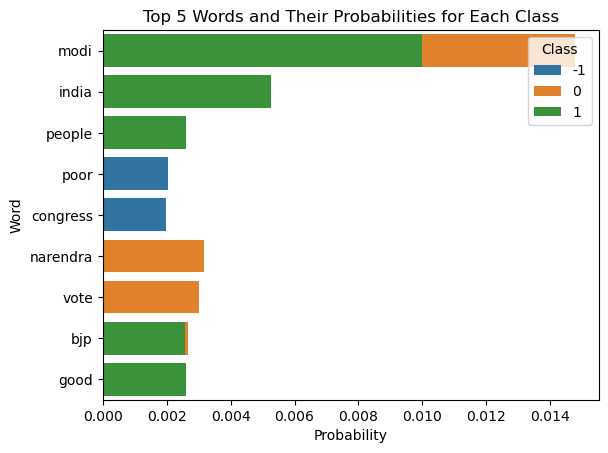

In [46]:
#Now we will visualzie the probabilities of the top 5 words in each class and view them as a barplot for easier understanding
top_words_data = []

# Populate the list with the top words and their probabilities for each class
for i, class_label in enumerate([-1, 0, 1]):
    # Find the indices of the top 5 words for the current class based on feature log probabilities
    top_word_indices = feature_log_probabilities[i].argsort()[-5:][::-1]
    # Get the top words and their probabilities
    top_words = [feature_names[idx] for idx in top_word_indices]
    top_probabilities = [np.exp(feature_log_probabilities[i][idx]) for idx in top_word_indices]
    # Append the top words and their probabilities to the list
    for word, probability in zip(top_words, top_probabilities):
        top_words_data.append({'Class': class_label, 'Word': word, 'Probability': probability})

# Convert the list of dictionaries to a DataFrame
top_words_df = pd.DataFrame(top_words_data)

# Convert the 'Class' column to categorical
top_words_df['Class'] = top_words_df['Class'].astype('category')

#Converting the 'Word' and 'Class' column to string
top_words_df['Word'] = top_words_df['Word'].astype(str)
top_words_df['Class'] = top_words_df['Class'].astype(str)

# Plot the top words and their probabilities for each class
sns.barplot(data=top_words_df, x='Probability', y='Word', hue='Class', dodge=False)
plt.xlabel('Probability')
plt.ylabel('Word')
plt.title('Top 5 Words and Their Probabilities for Each Class')
plt.show()

Time for some feature engineering and visuals now 

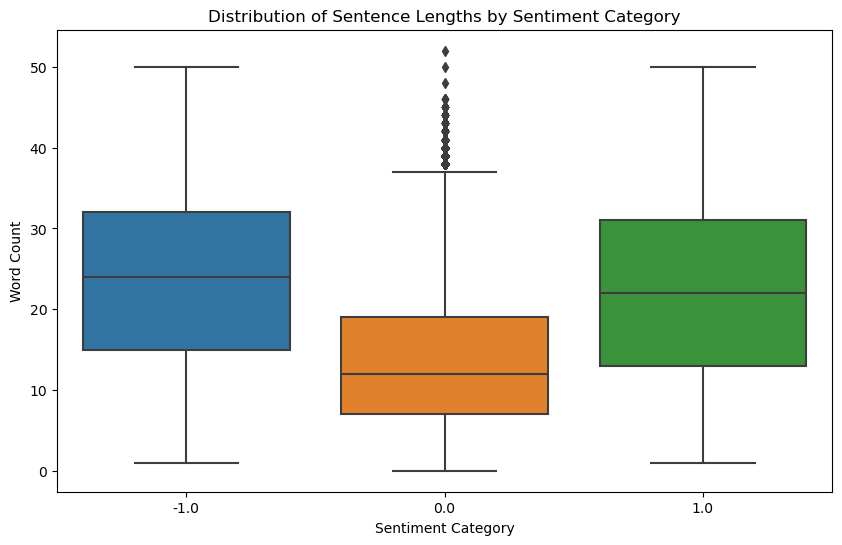

In [47]:
#Let us start with setence length in no.of words to see if we can correlate no.of words with their sentiments
#Counting no.of words
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# Visualizing distributions of sentence lengths for each sentiment category
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='category', y='word_count')
plt.xlabel('Sentiment Category')
plt.ylabel('Word Count')
plt.title('Distribution of Sentence Lengths by Sentiment Category')
plt.show()

In [48]:
word_count_stats = df['word_count'].describe()
print("Minimum word count:", word_count_stats['min'])
print("Maximum word count:", word_count_stats['max'])
print("Mean word count:", word_count_stats['mean'])

Minimum word count: 0.0
Maximum word count: 52.0
Mean word count: 19.852739053602985


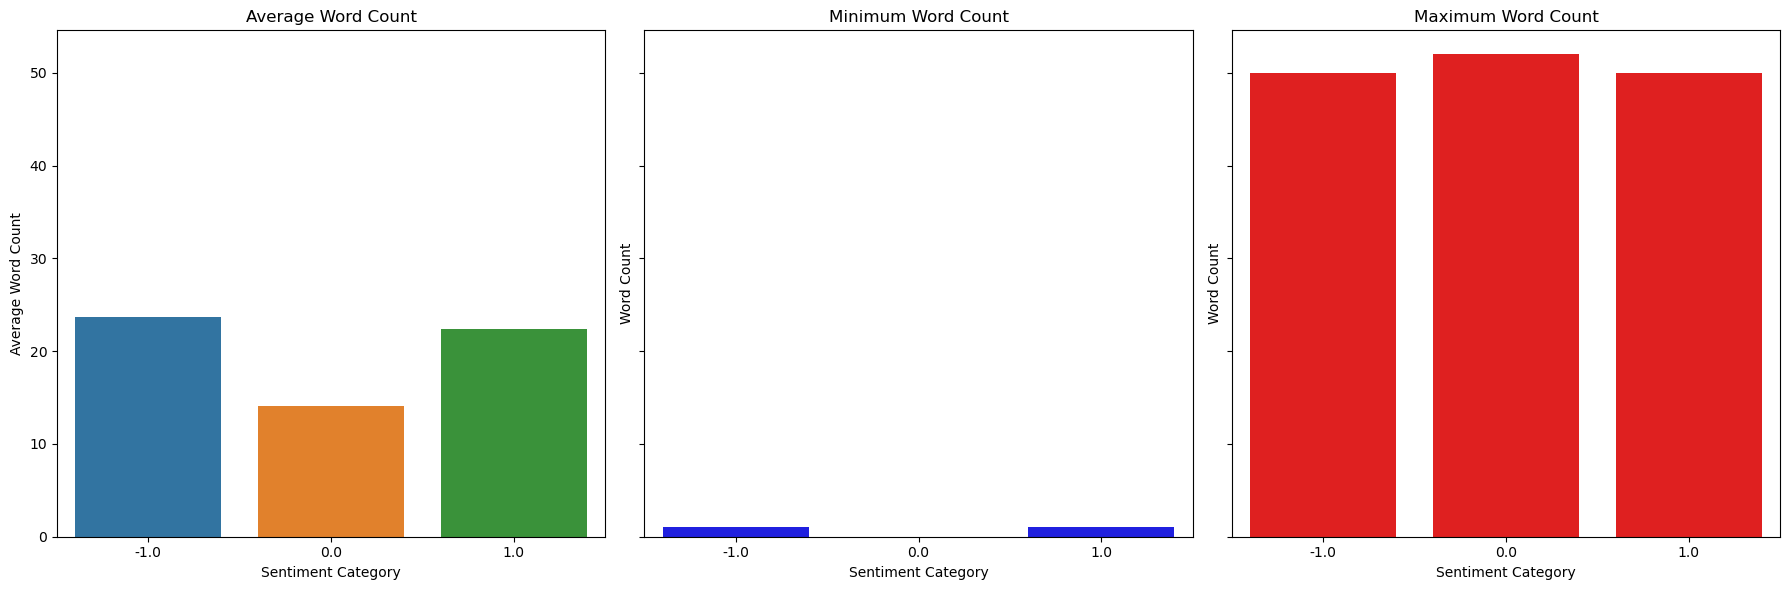

In [49]:
#Now we will show the mean word count and range of words in each sentiment class
grouped_df = df.groupby('category')

# Compute the average word count for each sentiment category
avg_word_count = grouped_df['word_count'].mean()

# Compute the range of word counts (minimum and maximum) for each sentiment category
min_word_count = grouped_df['word_count'].min()
max_word_count = grouped_df['word_count'].max()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot average word count for each sentiment category
sns.barplot(x=avg_word_count.index, y=avg_word_count.values, ax=axes[0])
axes[0].set_title('Average Word Count')
axes[0].set_xlabel('Sentiment Category')
axes[0].set_ylabel('Average Word Count')

# Plot minimum word count for each sentiment category
sns.barplot(x=min_word_count.index, y=min_word_count.values, color='blue', ax=axes[1])
axes[1].set_title('Minimum Word Count')
axes[1].set_xlabel('Sentiment Category')
axes[1].set_ylabel('Word Count')

# Plot maximum word count for each sentiment category
sns.barplot(x=max_word_count.index, y=max_word_count.values, color='red', ax=axes[2])
axes[2].set_title('Maximum Word Count')
axes[2].set_xlabel('Sentiment Category')
axes[2].set_ylabel('Word Count')

plt.tight_layout()
plt.show()

We can clearly see, texts with negative sentiment tend to have more words compared to positive or neutral. Neutral having the least

In [50]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon and nltk tokenizer if not already downloaded
nltk.download('vader_lexicon')
nltk.download('punkt')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
#Let us find sentiment-lexicons to analyse sentiments even more
# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Tokenize and preprocess the text data without removing stopwords
preprocessed_data = []
for text in df['clean_text']:
    tokens = nltk.word_tokenize(text.lower())  # Tokenization and lowercasing
    preprocessed_data.append(tokens)

# Assign sentiment scores using VADER lexicon
sentiment_scores = []
for tokens in preprocessed_data:
    scores = sid.polarity_scores(' '.join(tokens))  # Join tokens into a single string
    sentiment_scores.append(scores['compound'])  # Use compound score as overall sentiment score

# Print sentiment scores for each document
for i, score in enumerate(sentiment_scores):
    print(f"Document {i+1}: Sentiment Score = {score}")

# Aggregate sentiment scores to compute overall sentiment for each document
overall_sentiment = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in sentiment_scores]

# Print overall sentiment for each document
for i, sentiment in enumerate(overall_sentiment):
    print(f"Document {i+1}: Overall Sentiment = {sentiment}")

Document 1: Sentiment Score = 0.5267
Document 2: Sentiment Score = -0.4019
Document 3: Sentiment Score = 0.7096
Document 4: Sentiment Score = -0.0713
Document 5: Sentiment Score = 0.4754
Document 6: Sentiment Score = 0.0
Document 7: Sentiment Score = 0.7506
Document 8: Sentiment Score = 0.3612
Document 9: Sentiment Score = 0.2023
Document 10: Sentiment Score = 0.0
Document 11: Sentiment Score = 0.6124
Document 12: Sentiment Score = 0.8934
Document 13: Sentiment Score = 0.3182
Document 14: Sentiment Score = 0.4939
Document 15: Sentiment Score = 0.4939
Document 16: Sentiment Score = 0.6597
Document 17: Sentiment Score = -0.1877
Document 18: Sentiment Score = 0.3818
Document 19: Sentiment Score = 0.5667
Document 20: Sentiment Score = -0.5106
Document 21: Sentiment Score = 0.2828
Document 22: Sentiment Score = 0.0
Document 23: Sentiment Score = -0.743
Document 24: Sentiment Score = -0.4306
Document 25: Sentiment Score = -0.7067
Document 26: Sentiment Score = 0.5574
Document 27: Sentiment S

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



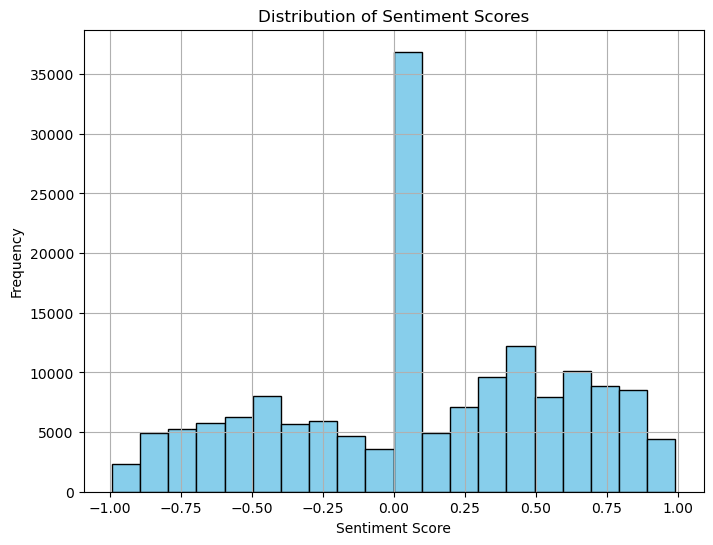

In [52]:
#Lets plot the new sentiment scores
plt.figure(figsize=(8, 6))
plt.hist(sentiment_scores, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.grid(True)
plt.show()

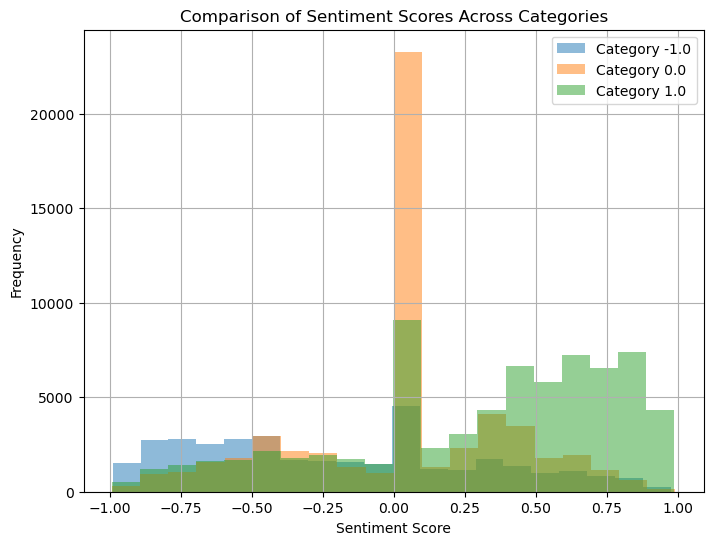

In [53]:
#Lets comapre the sentiment scores we received using lexicons across category
plt.figure(figsize=(8, 6))
for category in df['category'].unique():
    category_scores = [score for score, cat in zip(sentiment_scores, df['category']) if cat == category]
    plt.hist(category_scores, bins=20, alpha=0.5, label=f'Category {category}')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Comparison of Sentiment Scores Across Categories')
plt.legend()
plt.grid(True)
plt.show()

Now we will be discussing the readability of a text

In [54]:
import textstat
df['flesch_reading_ease'] = df['clean_text'].apply(textstat.flesch_reading_ease)
df['flesch_kincaid_grade'] = df['clean_text'].apply(textstat.flesch_kincaid_grade)
df['gunning_fog'] = df['clean_text'].apply(textstat.gunning_fog)
df['smog_index'] = df['clean_text'].apply(textstat.smog_index)

In [55]:
df[['clean_text', 'flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'smog_index']]

,clean_text,flesch_reading_ease,flesch_kincaid_grade,gunning_fog,smog_index
0,when modi promised minimum government maximum ...,37.98,16.2,20.47,0.0
1,talk all the nonsense and continue all the dra...,75.20,6.0,8.28,0.0
2,what did just say vote for modi welcome bjp t...,74.53,8.3,10.62,0.0
3,asking his supporters prefix chowkidar their n...,53.89,14.2,17.13,0.0
4,answer who among these the most powerful world...,74.19,6.4,5.60,0.0
...,...,...,...,...,...
162971,why these crores paid neerav modi not recover...,62.68,8.7,9.15,0.0
162972,dear rss terrorist payal gawar what about modi...,27.49,18.1,22.00,0.0
162973,did you cover her interaction forum where she ...,62.34,6.8,8.04,0.0
162974,there big project came into india modi dream p...,66.74,7.2,8.28,0.0


Flesch Reading Ease Score: Measures the readability of a text on a scale from 0 to 100, with higher scores indicating easier readability.

Flesch-Kincaid Grade Level: Estimates the grade level required to understand the text based on sentence length and syllable count.

Gunning Fog Index: Estimates the number of years of formal education needed to understand the text based on sentence length and percentage of complex words.

SMOG Index: Estimates the grade level required to understand the text based on the number of complex words.

In [56]:
df[['flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'smog_index']].mean()

flesch_reading_ease     53.466809
flesch_kincaid_grade    10.737929
gunning_fog             11.613924
smog_index               0.000000
dtype: float64

We can see the readability of the texts in twitter isnt the easiest to decipher and read becasue of poor grammatical syntax and improper spellings. But the education level required to understand the texts isnt so high either according to the other metrices.

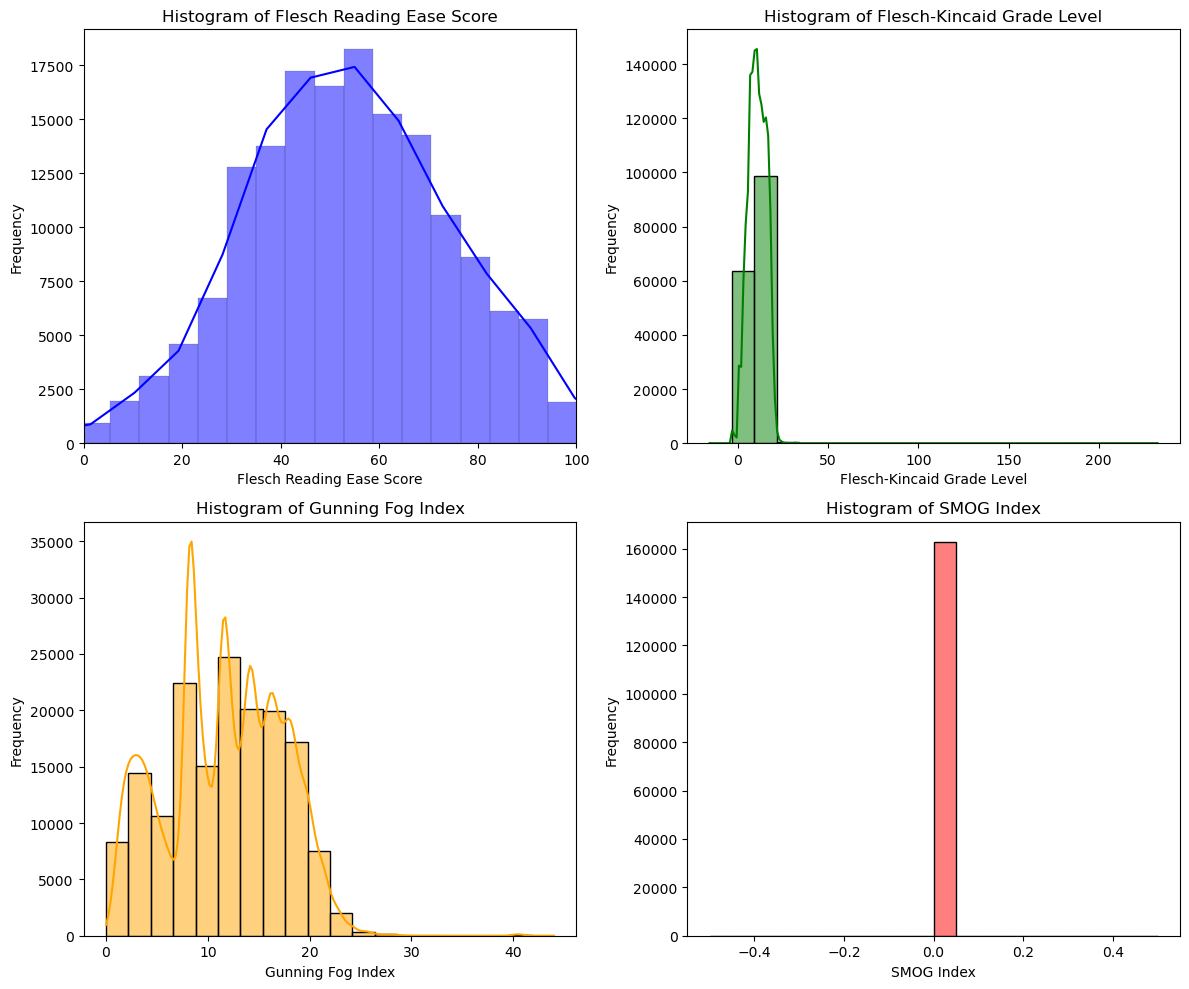

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plotting histograms for each readability metric
sns.histplot(df['flesch_reading_ease'], bins=300, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Histogram of Flesch Reading Ease Score')
axes[0].set_xlabel('Flesch Reading Ease Score')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 100)

sns.histplot(df['flesch_kincaid_grade'], bins=20, kde=True, ax=axes[1], color='green')
axes[1].set_title('Histogram of Flesch-Kincaid Grade Level')
axes[1].set_xlabel('Flesch-Kincaid Grade Level')
axes[1].set_ylabel('Frequency')

sns.histplot(df['gunning_fog'], bins=20, kde=True, ax=axes[2], color='orange')
axes[2].set_title('Histogram of Gunning Fog Index')
axes[2].set_xlabel('Gunning Fog Index')
axes[2].set_ylabel('Frequency')

sns.histplot(df['smog_index'], bins=20, kde=True, ax=axes[3], color='red')
axes[3].set_title('Histogram of SMOG Index')
axes[3].set_xlabel('SMOG Index')
axes[3].set_ylabel('Frequency')

# Adjusting the layout of the plot
plt.tight_layout()
plt.show()

In [58]:
df.to_excel('setiment_analysis.xlsx', index=False)